In [10]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
from comet_ml import Experiment
from tensorflow.keras import mixed_precision
import optuna
import numpy as np
import tensorflow as tf
import keras
from utils.Dataset import Dataset
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.inception_v3 import preprocess_input
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
print("✅ Imports ready!")

gpus = tf.config.list_physical_devices('GPU')
mixed_precision.set_global_policy("mixed_float16")
AUTOTUNE = tf.data.AUTOTUNE
if "google.colab" in str(get_ipython()):
    !pip install comet_ml --quiet
    !pip install optuna --quiet
    !pip install -q git+https://github.com/tensorflow/addons.git
    !pip install --no-cache-dir -U crcmod --quiet > /dev/null 2>&1
    !pip install optuna_integration --quiet
    print("✅ Dependencies installed!")
    from google.colab import auth
    !git clone https://github.com/emiliodelgadouy/utils.git --quiet
    auth.authenticate_user()
    !gsutil cp gs://helen-data/dumps/images_original.tar.xz ./
    !tar -xvf images_original.tar.xz -C ./utils > /dev/null 2>&1
    print("✅ Data downloaded!")
print("✅ Env ready!")
print("✅ GPU available!" if tf.config.list_physical_devices("GPU") else "❌ NO GPU available!")


✅ Imports ready!
✅ Env ready!
✅ GPU available!


In [12]:
dataset = Dataset(lateralize_images=True, dataset_csv="./ds_balanced.csv")
full_train = dataset[(dataset["split"] == "training")]
ds_test = dataset[(dataset["split"] == "test")]
ds_train, ds_val = train_test_split(
    full_train,
    test_size=0.20,
    random_state=42,
    stratify=full_train["findings"]
)

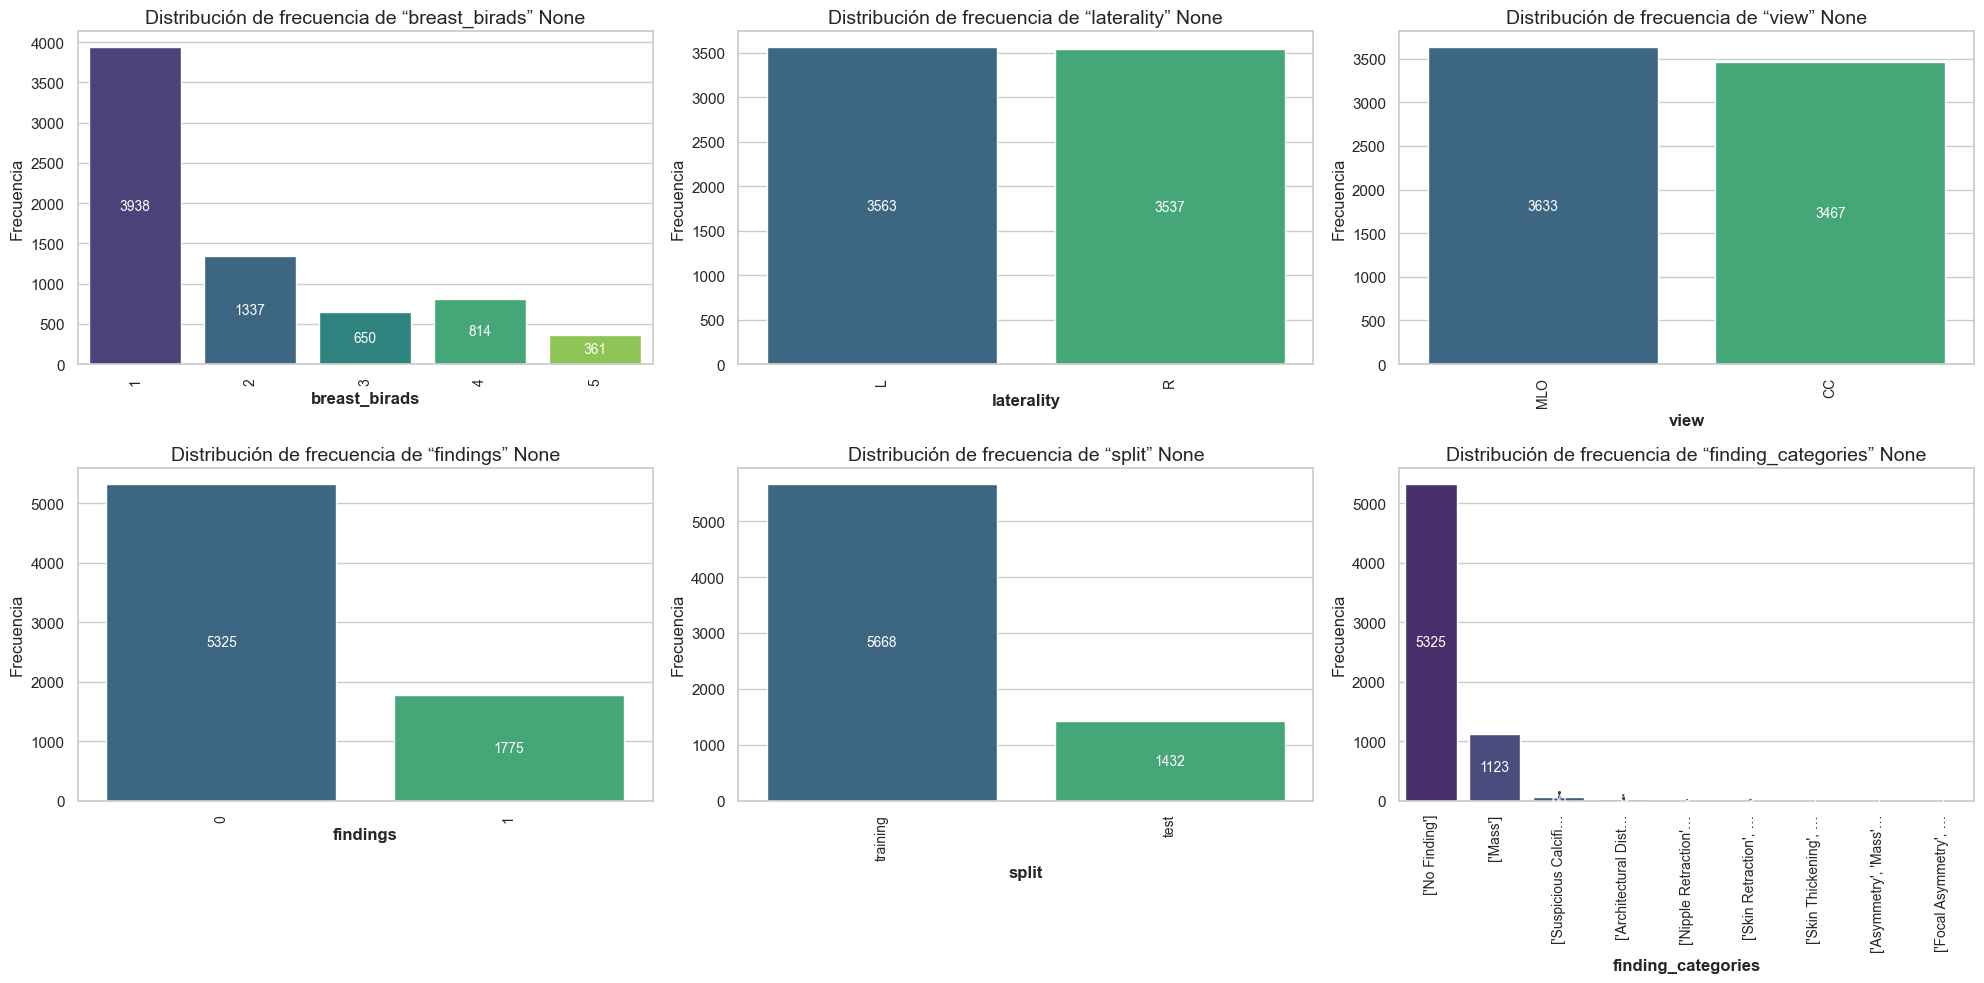

In [13]:
dataset.stats()

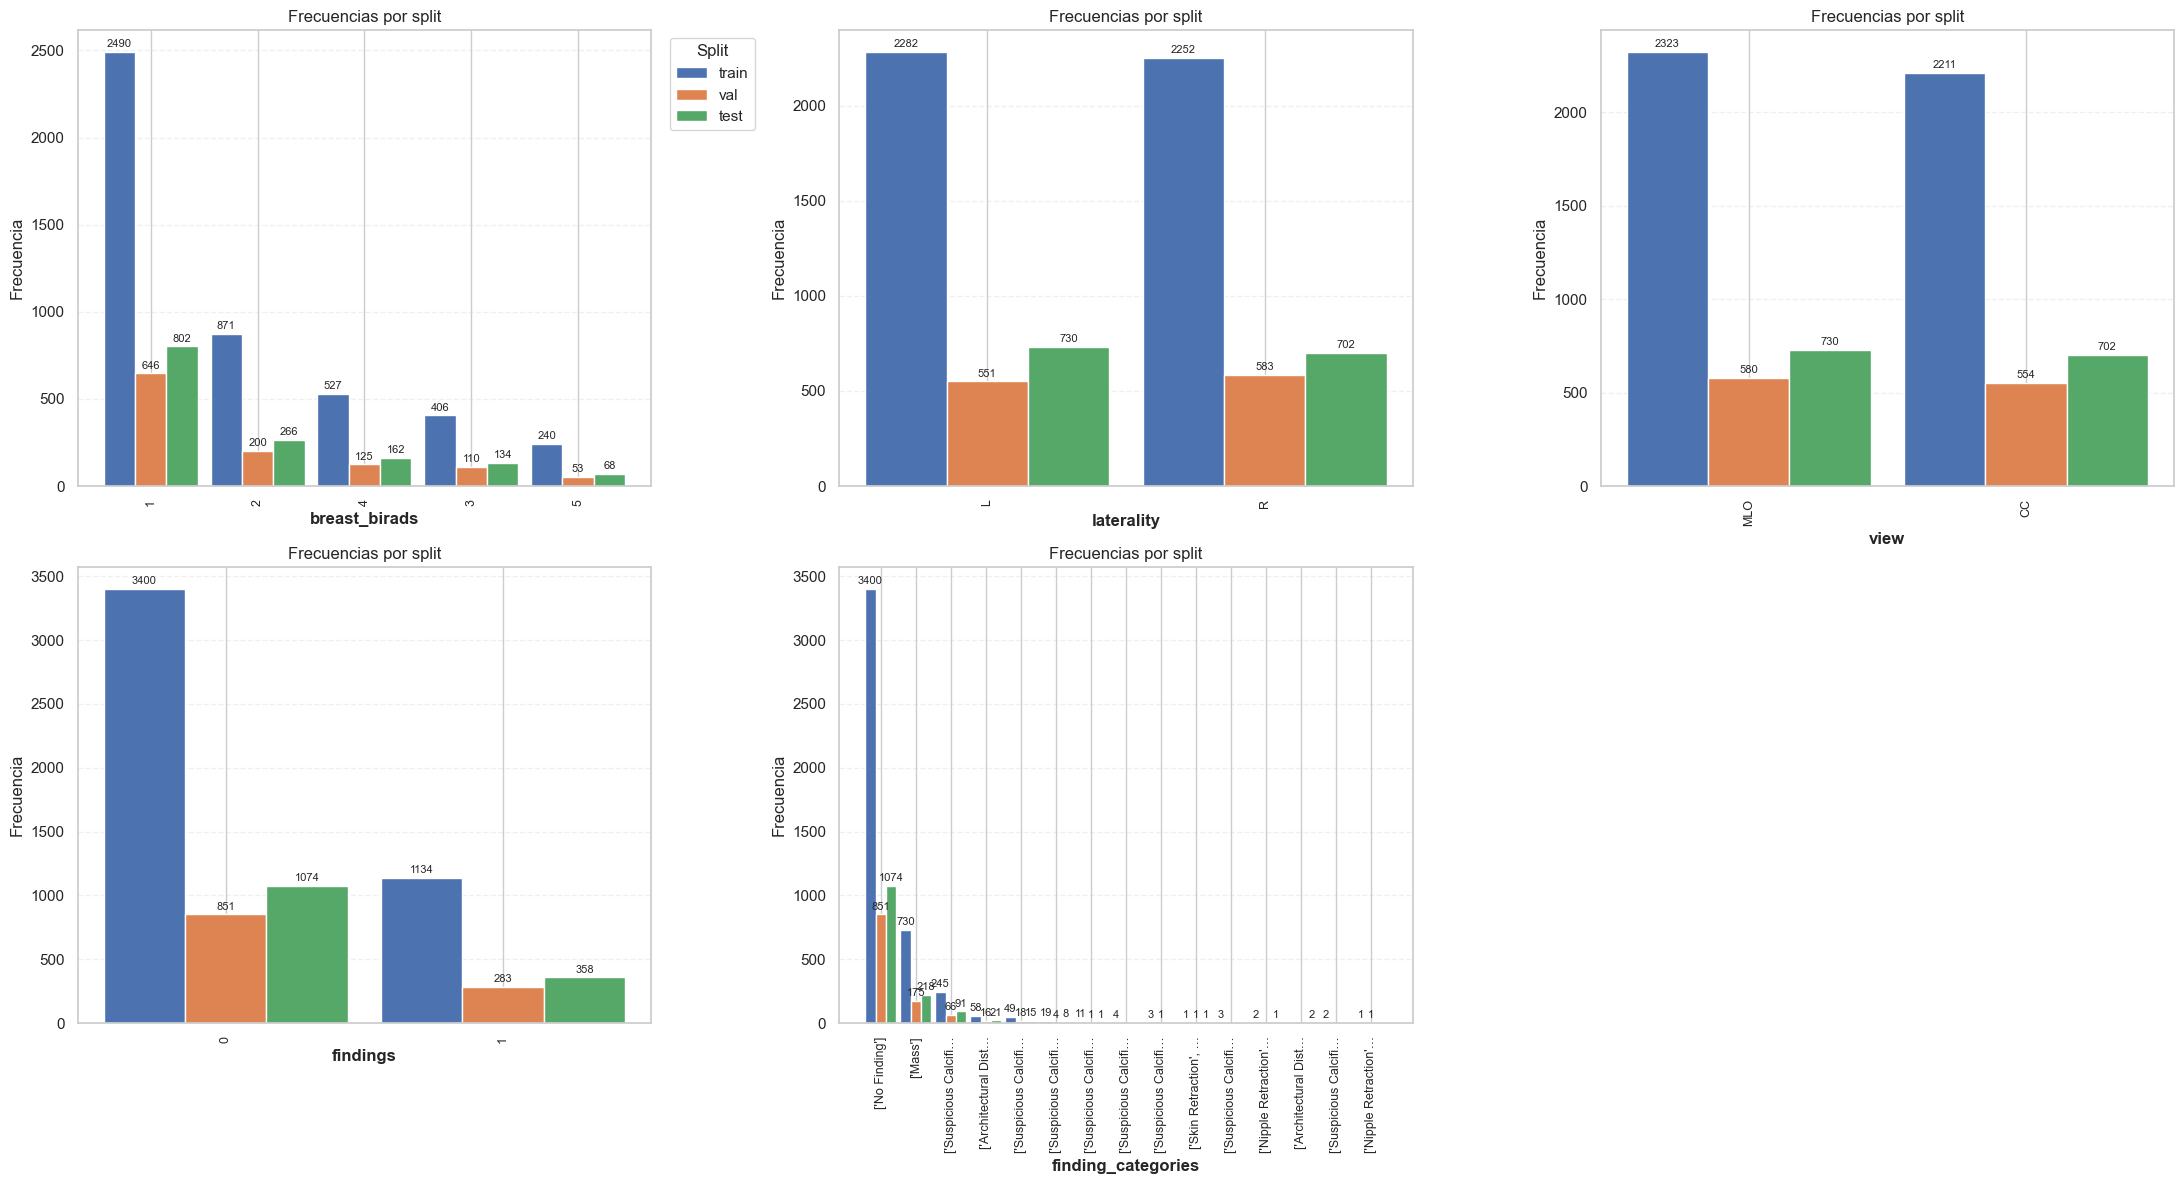

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_multiple_frequency_distributions_by_split(
    columns,
    splits=None,                 # dict: {"train": df, "val": df, "test": df}
    ancho=20, alto=10,
    ncols=3,
    order=None,                  # orden explícito de categorías (lista) opcional
    top_k=None,                  # mostrar solo top_k categorías por suma total
    title=None, subtitle=None,
    max_len=20
):
    """
    Grid de subplots (uno por columna), con barras agrupadas por split (train/val/test).
    Valores absolutos (no porcentajes).
    """
    # 0) Resolver splits
    if splits is None:
        # fallback: tratar de usar atributos típicos de la clase
        cand = {}
        for name in ("train", "val", "test"):
            df_attr = getattr(f"{name}_df", None)
            if isinstance(df_attr, pd.DataFrame):
                cand[name] = df_attr
        if not cand:
            raise ValueError("Debes pasar 'splits'={'train': df, 'val': df, 'test': df} o definir self.train_df / self.val_df / self.test_df.")
        splits = cand

    split_names = list(splits.keys())
    if len(split_names) == 0:
        raise ValueError("El dict 'splits' está vacío.")

    # 1) Preparar figure/axes
    n = len(columns)
    ncols = int(ncols)
    nrows = math.ceil(n / ncols)
    fig, axs = plt.subplots(nrows, ncols, figsize=(ancho, alto))
    axs = np.atleast_1d(axs).flatten()

    # 2) Paleta simple
    default_colors = plt.rcParams['axes.prop_cycle'].by_key().get('color', [])
    if not default_colors:
        default_colors = ["#4C72B0", "#55A868", "#C44E52", "#8172B2", "#CCB974", "#64B5CD"]

    # 3) Iterar columnas
    for i, col in enumerate(columns):
        ax = axs[i]

        # 3.1) Conteo por split y unión de categorías
        freqs = {}
        cat_union = set()
        for split, df in splits.items():
            if col not in df.columns:
                # si falta la columna en un split, cuenta 0
                freqs[split] = pd.Series(dtype=float)
                continue
            s = df[col]
            if s.apply(lambda x: isinstance(x, list)).any():
                s = s.explode()
            vc = s.value_counts(dropna=False)
            freqs[split] = vc
            cat_union.update(vc.index.tolist())

        # 3.2) Orden de categorías
        if order is None:
            totals = {c: sum(freqs[sp].get(c, 0) for sp in freqs) for c in cat_union}
            cats = [c for c, _ in sorted(totals.items(), key=lambda kv: kv[1], reverse=True)]
        else:
            extra = [c for c in cat_union if c not in order]
            cats = list(order) + sorted(extra, key=lambda x: (pd.isna(x), str(x)))

        # 3.3) Matriz categorías x splits
        M = pd.DataFrame({sp: pd.Series(freqs[sp]) for sp in split_names}).reindex(cats).fillna(0)

        # 3.4) top_k opcional
        if top_k:
            keep = M.sum(axis=1).nlargest(top_k).index
            M = M.loc[keep]
            cats = list(keep)

        # 3.5) Plot agrupado ABSOLUTO
        x = np.arange(len(cats))
        n_splits = len(split_names)
        if n_splits == 0 or len(cats) == 0:
            ax.set_title(f"{col} — sin datos")
            ax.axis('off')
            continue

        group_width = 0.88
        bar_w = group_width / n_splits

        for j, sp in enumerate(split_names):
            offset = (j - (n_splits - 1) / 2) * bar_w
            y = M[sp].values
            color = default_colors[j % len(default_colors)]
            bars = ax.bar(x + offset, y, width=bar_w, label=sp, color=color, align='center')

            # anotaciones
            for b, val in zip(bars, y):
                if val > 0:
                    ax.annotate(
                        f"{int(val)}",
                        (b.get_x() + b.get_width()/2, b.get_height()),
                        ha="center", va="bottom", fontsize=8, xytext=(0, 2),
                        textcoords="offset points"
                    )

        # 3.6) Ejes y títulos
        def short_label(s):
            s = str(s)
            return s[:max_len] + "…" if len(s) > max_len else s

        ax.set_xticks(x)
        ax.set_xticklabels([short_label(c) for c in cats], rotation=90, fontsize=9)
        ax.set_ylabel("Frecuencia")
        ax.set_xlabel(col, fontweight="bold")
        ax.set_title(title or f"Distribución de “{col}”" + (f" — {subtitle}" if subtitle else ""), fontsize=12)

        ax.grid(axis='y', linestyle='--', alpha=0.3)

        # leyenda solo en el primer subplot para no saturar
        if i == 0:
            ax.legend(title="Split", bbox_to_anchor=(1.02, 1), loc="upper left")
        else:
            ax.legend_.remove() if ax.legend_ else None

    # 4) Eliminar ejes vacíos si sobran
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()


splits = {"train": ds_train, "val": ds_val, "test": ds_test}
cols = ["breast_birads","laterality","view", "findings", "finding_categories"]

plot_multiple_frequency_distributions_by_split(
    columns=cols,
    splits=splits,
    top_k=15,               # opcional
    order=None,             # o una lista con el orden de categorías
    title="Frecuencias por split",
    subtitle="ABS (no normalizado)",
    ancho=22, alto=12, ncols=3
)


In [15]:
IMG_SIZE = (299, 299)
BATCH_SIZE = 32
EPOCHS = 200

labels_train_np = ds_train["findings"].astype("int64").to_numpy()
classes = np.unique(labels_train_np)
weights = class_weight.compute_class_weight('balanced', classes=classes, y=labels_train_np)
cw = {int(c): float(w) for c, w in zip(classes, weights)}

keys = tf.constant(list(cw.keys()), dtype=tf.int64)
vals = tf.constant(list(cw.values()), dtype=tf.float32)

class_weight_table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(keys, vals),
    default_value=tf.constant(1.0, tf.float32)
)

In [16]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
from tensorflow.keras.applications.inception_v3 import preprocess_input

# --- AUGMENT (sigue stateful; si querés también determinista por path, lo cambiamos) ---
def _augment(img):
    # Rotación aleatoria (±10°)
    angle = tf.random.uniform([], -10, 10) * np.pi / 180.0
    img = tfa.image.rotate(img, angle, interpolation='BILINEAR')

    # Zoom aleatorio (crop + resize)
    zoom_scale = tf.random.uniform([], 0.9, 1.1)  # 90%–110%
    h = tf.shape(img)[0]; w = tf.shape(img)[1]
    new_h = tf.cast(tf.cast(h, tf.float32) * zoom_scale, tf.int32)
    new_w = tf.cast(tf.cast(w, tf.float32) * zoom_scale, tf.int32)
    img = tf.image.resize(img, (new_h, new_w))
    img = tf.image.resize_with_crop_or_pad(img, h, w)

    # Brillo / contraste
    img = tf.image.random_brightness(img, max_delta=0.1)
    img = tf.image.random_contrast(img, lower=0.9, upper=1.1)

    # Clampeo a [0,1]
    # img = tf.clip_by_value(img, 0.0, 1.0)
    return img

# --- SEED determinista SOLO por path ---
def _seed_from_path(path):
    # hash estable del path → int32
    h64 = tf.strings.to_hash_bucket_fast(path, 2**31 - 1)
    h32 = tf.cast(h64, tf.int32)
    # seed de 2 enteros; el 2do es una mezcla del primero
    s0 = tf.stack([h32, tf.bitwise.bitwise_xor(h32, tf.constant(0x9E3779B9 & 0x7fffffff, tf.int32))])
    return s0  # shape [2], int32

def _preprocess_and_weight(img, label):
    y = tf.cast(label, tf.float32)
    y_int = tf.cast(label, tf.int64)
    sw = class_weight_table.lookup(y_int)
    img = preprocess_input(img)
    return img, y, sw

def _safe_float_col(df, name):
    if name in df.columns:
        return df[name].astype("float32").to_numpy()
    return np.full((len(df),), np.nan, dtype="float32")

def _build_slices(df):
    paths = df["path"].astype(str).to_numpy()
    labels = df["findings"].astype("float32").to_numpy()
    laterality  = df["laterality"].astype(str).to_numpy() if "laterality" in df.columns else np.array([""] * len(df))
    xmin = _safe_float_col(df, "xmin")
    ymin = _safe_float_col(df, "ymin")
    xmax = _safe_float_col(df, "xmax")
    ymax = _safe_float_col(df, "ymax")
    return paths, labels, laterality, xmin, ymin, xmax, ymax

def _center_crop(img, target_hw):
    th, tw = target_hw[0], target_hw[1]
    h = tf.shape(img)[0]; w = tf.shape(img)[1]
    tf.debugging.assert_greater_equal(h, th, message="Imagen demasiado chica en altura para crop")
    tf.debugging.assert_greater_equal(w, tw, message="Imagen demasiado chica en ancho para crop")
    y0 = tf.maximum(0, (h - th) // 2); x0 = tf.maximum(0, (w - tw) // 2)
    y0 = tf.minimum(y0, h - th); x0 = tf.minimum(x0, w - tw)
    return tf.image.crop_to_bounding_box(img, y0, x0, th, tw)

def _center_crop_on_point(img, cx, cy, target_hw):
    th, tw = target_hw[0], target_hw[1]
    h = tf.shape(img)[0]; w = tf.shape(img)[1]
    tf.debugging.assert_greater_equal(h, th, message="Imagen demasiado chica en altura para crop")
    tf.debugging.assert_greater_equal(w, tw, message="Imagen demasiado chica en ancho para crop")
    y0 = tf.cast(tf.round(cy - tf.cast(th, tf.float32) / 2.0), tf.int32)
    x0 = tf.cast(tf.round(cx - tf.cast(tw, tf.float32) / 2.0), tf.int32)
    y0 = tf.clip_by_value(y0, 0, h - th); x0 = tf.clip_by_value(x0, 0, w - tw)
    return tf.image.crop_to_bounding_box(img, y0, x0, th, tw)

def _maybe_flip_left_right(img, lat_str):
    lat = tf.strings.upper(lat_str)
    is_right = tf.strings.regex_full_match(lat, r"(R(IGHT)?)|(.*-R$)|(^R-.*)")
    return is_right, tf.cond(is_right, lambda: tf.image.flip_left_right(img), lambda: img)

def _flip_roi_if_needed(is_right, img, xmin, ymin, xmax, ymax):
    w = tf.shape(img)[1]
    def _flip():
        x_min2 = tf.cast(w - 1, tf.float32) - xmax
        x_max2 = tf.cast(w - 1, tf.float32) - xmin
        return x_min2, ymin, x_max2, ymax
    def _same():
        return xmin, ymin, xmax, ymax
    return tf.cond(is_right, _flip, _same)

def _roi_valid(xmin, ymin, xmax, ymax):
    return (
        tf.math.is_finite(xmin) & tf.math.is_finite(ymin) &
        tf.math.is_finite(xmax) & tf.math.is_finite(ymax) &
        (xmax > xmin) & (ymax > ymin)
    )

def _draw_bb(img, xmin, ymin, xmax, ymax):
    h = tf.shape(img)[0]; w = tf.shape(img)[1]
    ymin_n = ymin / tf.cast(h, tf.float32)
    xmin_n = xmin / tf.cast(w, tf.float32)
    ymax_n = ymax / tf.cast(h, tf.float32)
    xmax_n = xmax / tf.cast(w, tf.float32)
    boxes = tf.stack([ymin_n, xmin_n, ymax_n, xmax_n])[tf.newaxis, tf.newaxis, :]
    return tf.image.draw_bounding_boxes(img[tf.newaxis], boxes, colors=[[1.0, 0.0, 0.0]])[0]

def _load_roi(path, label, lat, xmin, ymin, xmax, ymax):
    bytes_ = tf.io.read_file(path)
    img = tf.io.decode_image(bytes_, channels=3, expand_animations=False)
    img = tf.image.convert_image_dtype(img, tf.float32)  # [0,1]
    is_right, img = _maybe_flip_left_right(img, lat)
    # xmin, ymin, xmax, ymax = _flip_roi_if_needed(is_right, img, xmin, ymin, xmax, ymax)
    return img, label, path, xmin, ymin, xmax, ymax

# ---------- TRAIN MAPPER (determinista por path) ----------
def _train_map_roi(img, label, path, xmin, ymin, xmax, ymax):
    target = tf.constant(IMG_SIZE, tf.int32)  # (H, W)
    th, tw = target[0], target[1]

    pos = tf.equal(tf.cast(label, tf.int32), 1)
    valid = _roi_valid(xmin, ymin, xmax, ymax)
    base_seed = _seed_from_path(path)

    def _pos_branch():
        h = tf.shape(img)[0]; w = tf.shape(img)[1]
        # Centro ROI (o centro imagen si ROI inválido)
        cx = tf.where(valid, (xmin + xmax) / 2.0, tf.cast(w, tf.float32) / 2.0)
        cy = tf.where(valid, (ymin + ymax) / 2.0, tf.cast(h, tf.float32) / 2.0)
        # Jitter relativo al tamaño del ROI (±40%) - determinista
        roi_w = tf.where(valid, xmax - xmin, tf.cast(w, tf.float32))
        roi_h = tf.where(valid, ymax - ymin, tf.cast(h, tf.float32))
        sx = tf.random.experimental.stateless_fold_in(base_seed, 101)
        sy = tf.random.experimental.stateless_fold_in(base_seed, 102)
        jx = tf.random.stateless_uniform([], minval=-0.4, maxval=0.4, seed=sx, dtype=tf.float32)
        jy = tf.random.stateless_uniform([], minval=-0.4, maxval=0.4, seed=sy, dtype=tf.float32)
        cx_jit = cx + jx * roi_w
        cy_jit = cy + jy * roi_h
        out = _center_crop_on_point(img, cx_jit, cy_jit, target)
        return tf.ensure_shape(out, (IMG_SIZE[0], IMG_SIZE[1], 3))

    def _neg_branch():
        h = tf.shape(img)[0]; w = tf.shape(img)[1]
        tf.debugging.assert_greater_equal(h, th, message="Imagen demasiado chica en altura para random crop")
        tf.debugging.assert_greater_equal(w, tw, message="Imagen demasiado chica en ancho para random crop")
        # Coordenadas deterministas por path
        sy0 = tf.random.experimental.stateless_fold_in(base_seed, 201)
        sx0 = tf.random.experimental.stateless_fold_in(base_seed, 202)
        y0 = tf.random.stateless_uniform((), minval=0, maxval=h - th + 1, seed=sy0, dtype=tf.int32)
        x0 = tf.random.stateless_uniform((), minval=0, maxval=w - tw + 1, seed=sx0, dtype=tf.int32)
        out = tf.image.crop_to_bounding_box(img, y0, x0, th, tw)
        return tf.ensure_shape(out, (IMG_SIZE[0], IMG_SIZE[1], 3))

    img2 = tf.cond(pos, _pos_branch, _neg_branch)
    return img2, label

# ---------- EVAL MAPPER (negativos también deterministas por path) ----------
def _eval_map_roi(img, label, path, xmin, ymin, xmax, ymax):
    target = tf.constant(IMG_SIZE, tf.int32)
    pos = tf.equal(tf.cast(label, tf.int32), 1)
    valid = _roi_valid(xmin, ymin, xmax, ymax)
    base_seed = _seed_from_path(path)

    def _pos():
        h = tf.shape(img)[0]; w = tf.shape(img)[1]
        cx = tf.where(valid, (xmin + xmax) / 2.0, tf.cast(w, tf.float32) / 2.0)
        cy = tf.where(valid, (ymin + ymax) / 2.0, tf.cast(h, tf.float32) / 2.0)
        out = _center_crop_on_point(img, cx, cy, target)
        return tf.ensure_shape(out, (IMG_SIZE[0], IMG_SIZE[1], 3))

    def _neg():
        th, tw = target[0], target[1]
        h = tf.shape(img)[0]; w = tf.shape(img)[1]
        tf.debugging.assert_greater_equal(h, th, message="Imagen demasiado chica en altura para random crop")
        tf.debugging.assert_greater_equal(w, tw, message="Imagen demasiado chica en ancho para random crop")
        sy0 = tf.random.experimental.stateless_fold_in(base_seed, 401)
        sx0 = tf.random.experimental.stateless_fold_in(base_seed, 402)
        y0 = tf.random.stateless_uniform((), minval=0, maxval=h - th + 1, seed=sy0, dtype=tf.int32)
        x0 = tf.random.stateless_uniform((), minval=0, maxval=w - tw + 1, seed=sx0, dtype=tf.int32)
        return tf.image.crop_to_bounding_box(img, y0, x0, th, tw)

    img2 = tf.cond(pos, _pos, _neg)
    return img2, label

# ==== DATASET BUILDER ====
def make_ds(df, training: bool, shuffle=False):
    paths, labels, later, xmin, ymin, xmax, ymax = _build_slices(df)

    ds = tf.data.Dataset.from_tensor_slices((paths, labels, later, xmin, ymin, xmax, ymax))
    if shuffle:
        ds = ds.shuffle(min(8192, len(df)), reshuffle_each_iteration=True)

    ds = ds.map(_load_roi, num_parallel_calls=AUTOTUNE)
    ds = ds.map(_train_map_roi if training else _eval_map_roi, num_parallel_calls=AUTOTUNE)

    if training:  # Augmentación solo para training
        ds = ds.map(lambda img, lbl: (_augment(img), lbl), num_parallel_calls=AUTOTUNE)

    ds = ds.map(_preprocess_and_weight, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE, drop_remainder=False).prefetch(AUTOTUNE)

    opts = tf.data.Options()
    opts.experimental_deterministic = False  # el orden puede variar; los crops son deterministas por path
    return ds.with_options(opts)

# ==== EJEMPLO DE USO ====
train_ds = make_ds(ds_train, training=True,  shuffle=True)
val_ds   = make_ds(ds_val,   training=False, shuffle=False)
test_ds  = make_ds(ds_test,  training=False, shuffle=False)


In [17]:
# val_ds   = make_ds(ds_val,   training=False)
# test_ds  = make_ds(ds_test,  training=False)

In [18]:
# import matplotlib.pyplot as plt
# import tensorflow as tf
#
# # Dataset fijo con 10 imágenes positivas
# explore_ds = make_ds(
#     ds_train[ds_train["findings"] == 1].sample(10),
#     training=True,
#     shuffle=False
# )
#
# N_AUGS = 3
#
# explore_list = list(explore_ds.unbatch().as_numpy_iterator())
#
# fig, axes = plt.subplots(len(explore_list), N_AUGS, figsize=(3 * N_AUGS, 3 * len(explore_list)))
#
# for i, (img, lbl, _) in enumerate(explore_list):
#     for j in range(N_AUGS):
#         one_df = ds_train[ds_train["findings"] == 1].iloc[[i]]
#         one_ds = make_ds(one_df, training=True, shuffle=False)
#
#         aug_img, aug_lbl, _ = next(iter(one_ds))
#         aug_img = (aug_img[0].numpy() + 1) / 2.0
#
#         ax = axes[i, j] if len(explore_list) > 1 else axes[j]
#         ax.imshow(aug_img)
#         ax.axis("off")
#         if j == 0:
#             ax.set_ylabel(f"Img {i} (Label={lbl:.0f})", fontsize=10)
#
# plt.tight_layout()
# plt.show()


In [19]:
import os, gc, time, random
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.layers import GlobalMaxPooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger, TerminateOnNaN
from optuna.integration import TFKerasPruningCallback
# from comet_ml import Experiment  # Asegúrate de tener comet_ml instalado

# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs/fit", histogram_freq=1, profile_batch='1,5')

def build_model(l2_reg, dropout_rate, unfreeze_pct):
    base = InceptionV3(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
    for l in base.layers:
        l.trainable = False
    n_total = len(base.layers)
    n_unfreeze = int(n_total * unfreeze_pct)
    if n_unfreeze > 0:
        for l in base.layers[-n_unfreeze:]:
            l.trainable = True

    x = base.output
    x = GlobalMaxPooling2D()(x)
    x = Dense(512, activation='relu',
              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-4, l2=l2_reg))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    out = Dense(1, activation='sigmoid', dtype='float32')(x)
    return Model(inputs=base.input, outputs=out)

def _make_callbacks(trial):
    os.makedirs("checkpoints", exist_ok=True)
    ckpt_path = os.path.join("checkpoints", f"model_trial_{trial.number}.weights.h5")

    # Early stopping sobre AUC (modo 'max'), y restaurar el mejor
    early = EarlyStopping(
        monitor='val_auc_roc',
        mode='max',
        patience=20,
        restore_best_weights=True,
        verbose=1
    )

    # Guardar el mejor checkpoint (por si querés persistirlo en disco)
    ckpt = ModelCheckpoint(
        ckpt_path,
        monitor='val_auc_roc',
        mode='max',
        save_best_only=True,
        save_weights_only=True,
        verbose=0
    )

    # Reducir LR cuando se estanque la métrica
    reduce = ReduceLROnPlateau(
        monitor='val_auc_roc',
        mode='max',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )

    # Log CSV por época
    csv = CSVLogger(f"training_trial_{trial.number}.csv", append=False)

    # Cortar si el loss produce NaN
    nan_killer = TerminateOnNaN()

    # Pruning de Optuna mirando val_auc_roc
    prune_cb = TFKerasPruningCallback(trial, monitor='val_auc_roc')

    return [early, ckpt, reduce, csv, nan_killer, prune_cb]
    # Si querés tensorboard:  + [tensorboard_callback]

def objective(trial):
    experiment = Experiment(
        api_key="W8IluWhLfvXgLr8ggg1bwZKTf",
        project_name="analisis",
        workspace="emiliodelgadouy",
        auto_output_logging="simple",
        log_code=False
    )
    experiment.set_name(f"TF_{trial.number}")

    # seeds
    random.seed(42); np.random.seed(42); tf.random.set_seed(42)

    # Optuna Hyperparameters
    lr          = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)
    dropout     = trial.suggest_float('dropout_rate', 0.2, 0.6)
    l2_reg      = trial.suggest_float('l2_reg', 1e-6, 1e-3, log=True)
    unfreeze_pc = trial.suggest_float("unfreeze_pct", 0.0, 0.3)

    experiment.log_parameters({
        "learning_rate": lr,
        "dropout_rate": dropout,
        "l2_reg": l2_reg,
        "backbone": "InceptionV3",
        "batch_size": BATCH_SIZE,
        "img_size": IMG_SIZE,
        "epochs": EPOCHS,
        "unfreeze_pct": unfreeze_pc
    })

    model = build_model(l2_reg, dropout, unfreeze_pc)
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy', AUC(name='auc_roc', curve='ROC')]
    )

    callbacks = _make_callbacks(trial)

    t0 = time.time()
    model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=1
    )
    elapsed = time.time() - t0

    # (Opcional) cargar los pesos del mejor checkpoint desde disco. No es necesario si usás restore_best_weights=True:
    # best_ckpt = os.path.join("checkpoints", f"model_trial_{trial.number}.weights.h5")
    # if os.path.exists(best_ckpt):
    #     model.load_weights(best_ckpt)

    # Evaluación final con los mejores pesos restaurados
    loss, acc, auc = model.evaluate(test_ds, verbose=1)

    experiment.log_metric("fit_time_sec", elapsed)
    experiment.log_metric("final_test_loss", loss)
    experiment.log_metric("final_test_accuracy", acc)
    experiment.log_metric("final_test_auc_roc", auc)
    experiment.end()

    # Liberar memoria
    del model
    tf.keras.backend.clear_session()
    gc.collect()

    # Maximizar accuracy (tal como pediste)
    return float(acc)


In [ ]:
    study = optuna.create_study(
        direction="maximize",
        study_name="inceptionv3_tuning"
    )
    study.optimize(objective, n_trials=5)

    print("Mejores hiperparámetros encontrados:")
    print(study.best_trial.params)
    print("Mejor accuracy:", study.best_trial.value)

[I 2025-09-01 14:21:30,183] A new study created in memory with name: inceptionv3_tuning
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/emiliodelgadouy/analisis/8325e36e66264f0bb1231a1e58e026e6

COMET WARNING: tensorflow datasets are not currently supported for gradient and activation auto-logging
COMET INFO: Ignoring automatic log_parameter('verbose') because 'keras:verbose' is in COMET_LOGGING_PARAMETERS_IGNORE


Epoch 1/200


I0000 00:00:1756747303.297292   58384 service.cc:152] XLA service 0x7ec868016c00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756747303.297360   58384 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-09-01 14:21:44.090395: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1756747305.667877   58384 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/142 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - accuracy: 0.5234 - auc_roc: 0.5281 - loss: 3.7344 

I0000 00:00:1756747314.790785   58384 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.5816 - auc_roc: 0.6532 - loss: 3.3237

In [38]:
# model = build_model(7.264053967723673e-06, 0.45531751951283506, 0.04916533198019358)
# model.load_weights("checkpoints/model_trial_3.weights.h5")


In [ ]:
# model.predict(train_ds)

In [41]:
# ds_test.iloc[0]["path"]

'utils/images_original/5683854eafabc34f6d854000d2ac6c2d/2f944efb1cb9579442df2d7fe6a579b7.png'

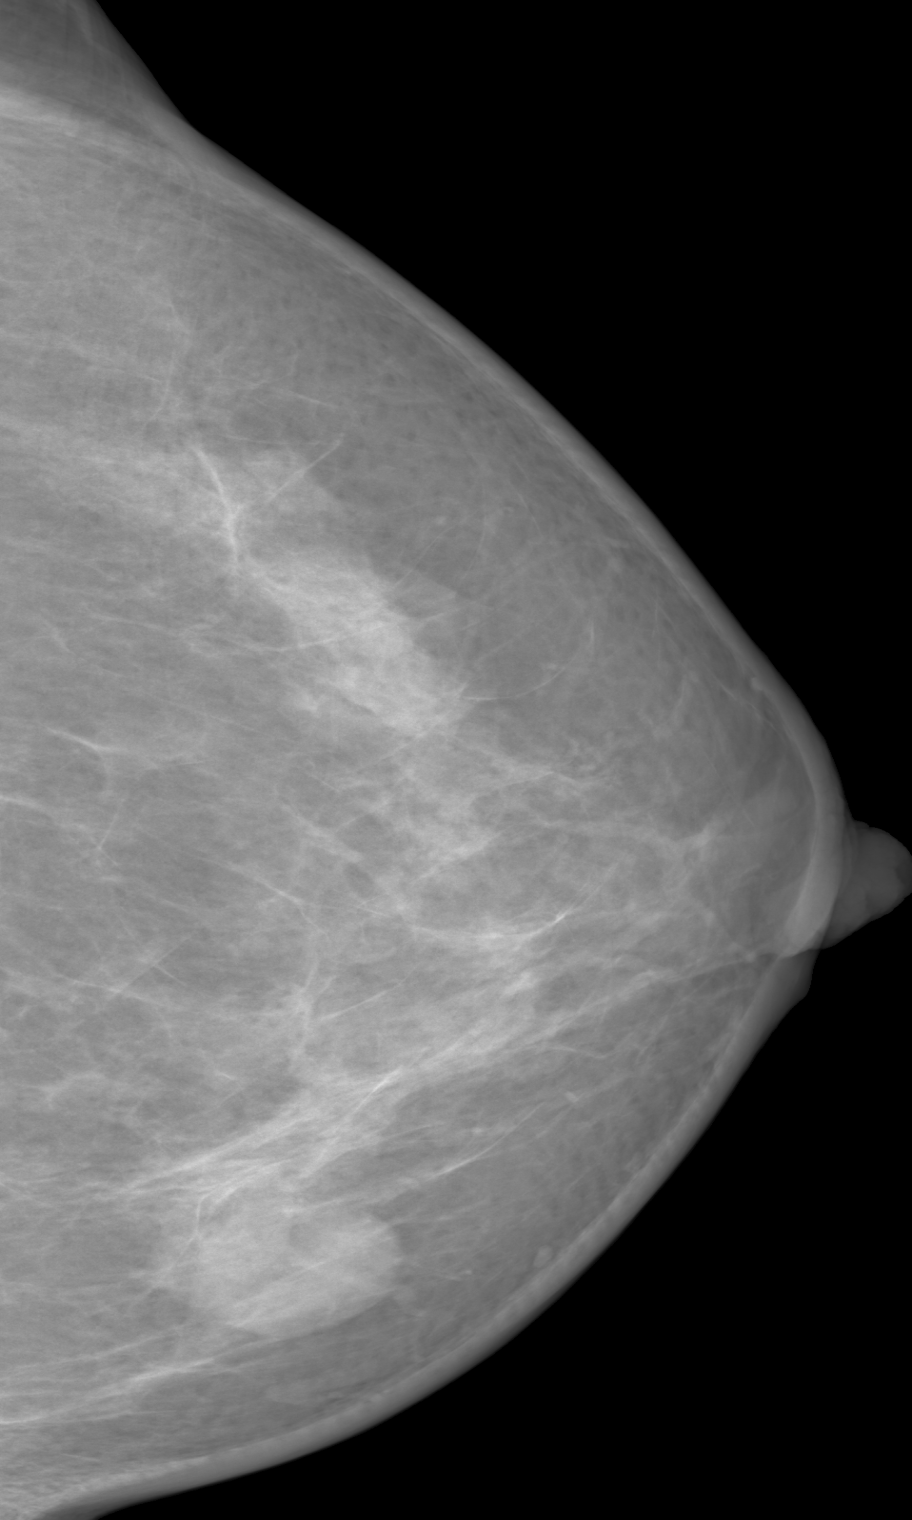

In [110]:
# from tensorflow.keras.preprocessing import image
#
# img = image.load_img(ds_test.iloc[i]["path"])


In [179]:
# ds_test

,laterality,view,breast_birads,finding_categories,finding_birads,split,xmin,ymin,xmax,ymax,path,findings
5668,L,CC,3,['Mass'],3.0,test,131.277547,1191.820266,413.717654,1340.771298,utils/images_original/5683854eafabc34f6d854000...,1
5669,L,MLO,3,['Mass'],3.0,test,122.936354,1125.611059,368.077144,1247.382004,utils/images_original/5683854eafabc34f6d854000...,1
5670,L,CC,3,['Mass'],3.0,test,176.509454,996.161495,528.361902,1274.063699,utils/images_original/917a4de3b1f921f1c9fa98b7...,1
5671,L,MLO,3,['Mass'],3.0,test,154.844007,732.731297,484.372837,867.280843,utils/images_original/917a4de3b1f921f1c9fa98b7...,1
5672,L,MLO,4,['Mass'],4.0,test,194.168852,1334.856248,382.826265,1402.476848,utils/images_original/31fa226bc9f87e0a2cb2de6d...,1
...,...,...,...,...,...,...,...,...,...,...,...,...
7095,R,MLO,1,['No Finding'],NaN,test,NaN,NaN,NaN,NaN,utils/images_original/436d8bc6249a84f919004ccb...,0
7096,R,MLO,1,['No Finding'],NaN,test,NaN,NaN,NaN,NaN,utils/images_original/cfac0d62a935de7dfd7df694...,0
7097,R,MLO,2,['No Finding'],NaN,test,NaN,NaN,NaN,NaN,utils/images_original/c8a495687fe74f6aa477d0bf...,0
7098,L,MLO,1,['No Finding'],NaN,test,NaN,NaN,NaN,NaN,utils/images_original/9b7e001b3af23c0daddccb62...,0


1


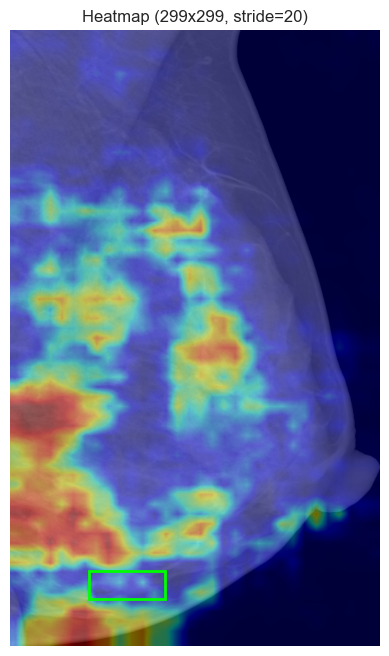

In [201]:
# import tensorflow as tf
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.patches import Rectangle
# from tensorflow.keras.preprocessing import image
#
# def sweep_heatmap(
#     model, path, crop_hw=(299,299), stride=75, batch_size=32,
#     roi=None,  # roi = (xmin, ymin, xmax, ymax) en coords originales
#     show=True, draw_roi=True, roi_color='lime', roi_linewidth=2.0
# ):
#     th, tw = crop_hw
#
#     # 1) Imagen original (sin resize) → [0,1] float32
#     pil = image.load_img(path)
#     img_arr = image.img_to_array(pil)            # (H,W,3) en [0,255]
#     img = tf.convert_to_tensor(img_arr, tf.float32) / 255.0
#     H = int(img.shape[0]); W = int(img.shape[1])
#
#     # 2) Posiciones del barrido (cubro bordes)
#     ys = list(range(0, max(H - th + 1, 1), stride))
#     xs = list(range(0, max(W - tw + 1, 1), stride))
#     if ys[-1] != max(H - th, 0): ys.append(max(H - th, 0))
#     if xs[-1] != max(W - tw, 0): xs.append(max(W - tw, 0))
#
#     # 3) Extraer parches
#     crops, coords = [], []
#     for yi, y0 in enumerate(ys):
#         for xi, x0 in enumerate(xs):
#             patch = tf.image.crop_to_bounding_box(img, y0, x0, th, tw)  # [0,1]
#             crops.append(patch)
#             coords.append((yi, xi))
#
#     if not crops:
#         raise ValueError("Imagen más pequeña que el parche y stride; ajusta parámetros.")
#
#     X = tf.stack(crops, axis=0)  # (N, th, tw, 3) en [0,1]
#
#     # 4) Predicción en batch
#     probs = model.predict(X, batch_size=batch_size, verbose=0).reshape(-1)
#
#     # 5) Mapa coarse (grid de posiciones) → resize a (H,W)
#     heat_grid = np.zeros((len(ys), len(xs)), dtype=np.float32)
#     for (yi, xi), p in zip(coords, probs):
#         heat_grid[yi, xi] = p
#
#     heat = tf.image.resize(
#         tf.convert_to_tensor(heat_grid, tf.float32)[..., tf.newaxis],
#         (H, W), method='bilinear'
#     )
#     heat = tf.squeeze(heat, -1).numpy()
#
#     # 6) Normalización visual [0,1]
#     hmin, hmax = float(heat.min()), float(heat.max())
#     heat_vis = (heat - hmin) / (hmax - hmin) if hmax > hmin else np.zeros_like(heat)
#
#     # 7) Mostrar + BB original
#     if show:
#         fig, ax = plt.subplots(figsize=(8, 8))
#         ax.imshow(img.numpy())
#         ax.imshow(heat_vis, alpha=0.45, cmap='jet')
#         ax.set_axis_off()
#         ax.set_title(f"Heatmap ({th}x{tw}, stride={stride})")
#
#         if draw_roi and roi is not None:
#             xmin, ymin, xmax, ymax = roi
#             # Validación simple
#             if np.isfinite([xmin,ymin,xmax,ymax]).all() and xmax > xmin and ymax > ymin:
#                 rect = Rectangle(
#                     (xmin, ymin), xmax - xmin, ymax - ymin,
#                     linewidth=roi_linewidth, edgecolor=roi_color, facecolor='none'
#                 )
#                 ax.add_patch(rect)
#         plt.show()
#
#     return heat, heat_vis  # heat en escala de probs, heat_vis en [0,1]
#
# # === Ejemplo de uso con ds_test ===
# CROP_SIZE = (299, 299)
# i = 4
# row = ds_test[ds_test["findings"]==1].iloc[i]
# path = row["path"]
# print(row["findings"])
#
# roi = None
# cols = {"xmin","ymin","xmax","ymax"}
# if cols.issubset(row.index):
#     roi = (float(row["xmin"]), float(row["ymin"]), float(row["xmax"]), float(row["ymax"]))
#
# heat, heat_vis = sweep_heatmap(
#     model,
#     path,
#     crop_hw=CROP_SIZE,
#     stride=20,
#     batch_size=32,
#     roi=roi,
#     show=True,
#     draw_roi=True,
#     roi_color='lime',
#     roi_linewidth=2.0
# )


In [163]:
# from sklearn.metrics import roc_auc_score
#
# ys = []
# ps = []
# for imgs, y, _ in test_ds.take(100):  # suficientes batches
#     p = model.predict(imgs, verbose=0)[:,0]
#     ys.append(y.numpy()); ps.append(p)
# ys = np.concatenate(ys).astype(int)
# ps = np.concatenate(ps)
# print("pred stats -> min:", ps.min(), " max:", ps.max(), " mean:", ps.mean())
# print("AUC:", roc_auc_score(ys, ps))
#
# th = 0.5
# pred01 = (ps >= th).astype(int)
# acc = (pred01==ys).mean()
# print("ACC@0.5:", acc, "  rate_positivos_predichos:", pred01.mean())


pred stats -> min: 2.541858e-05  max: 0.9999999  mean: 0.2863301
AUC: 0.9279386827294196
ACC@0.5: 0.8722067039106145   rate_positivos_predichos: 0.2604748603351955


In [ ]:
# N_AUGS = 5
#
# explore_list = list(explore_ds.unbatch().as_numpy_iterator())
#
# fig, axes = plt.subplots(len(explore_list), N_AUGS, figsize=(3 * N_AUGS, 3 * len(explore_list)))
#
# for i, (img, lbl, _) in enumerate(explore_list):
#     for j in range(N_AUGS):
#         one_df = ds_train[ds_test["findings"] == 1].iloc[[i]]
#         one_ds = make_ds(one_df, training=False, shuffle=False)
#
#         aug_img, aug_lbl, _ = next(iter(one_ds))
#         aug_img = (aug_img[0].numpy() + 1) / 2.0
#
#         ax = axes[i, j] if len(explore_list) > 1 else axes[j]
#         ax.imshow(aug_img)
#         ax.axis("off")
#         if j == 0:
#             ax.set_ylabel(f"Img {i} (Label={lbl:.0f})", fontsize=10)
#
# plt.tight_layout()
# plt.show()